# 07 - Hidden Markov state models (HMMs)

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

In this notebook, we will learn about hidden Markov state models and how to use them to deal with poor discretization.
We further explain how to obtain a coarse-grained model based on an initial MSM analysis.

The prequisites for this tutorial are
- data loading/visualization ([Notebook 01 ➜ 📓](01-data-io-and-featurization.ipynb))
- dimension reduction ([Notebook 02 ➜ 📓](02-dimension-reduction-and-discretization.ipynb))
- MSM estimation/validation ([Notebook 03 ➜ 📓](03-msm-estimation-and-validation.ipynb))
- basic analyis techniques ([Notebook 04 ➜ 📓](04-msm-analysis.ipynb) and [Notebook 05 ➜ 📓](05-pcca-tpt.ipynb))

Maintainers: [@cwehmeyer](https://github.com/cwehmeyer), [@marscher](https://github.com/marscher), [@thempel](https://github.com/thempel), [@psolsson](https://github.com/psolsson)

**Remember**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- you can find the full documentation at [PyEMMA.org](http://www.pyemma.org).

---

When estimating a regular MSM, we assume that the dynamics between microstates defined by our clustering algorithm is Markovian.
Hidden Markov models (HMMs), in comparison, only make this assumption in the space of so-called hidden states that have not been directly observed.
This means that instead of finding a maximum likelihood (ML) transition matrix between microstates,
an ML transition matrix is estimated between hidden states.
In the same step, the probability of a microstate to belong to a certain hidden state is estimated.

⚠️ Please note that the PyEMMA implementation internally initiates the estimation with a regular MSM and PCCA++.

There are two major use-cases for HMMs in PyEMMA:
- HMMs are more robust to poor space discretization and can be used to overcome difficult clustering situations
- HMMs offer a coarse graining into metastable (hidden) states

In this notebook, we will demonstrate how to estimate HMMs and how they behave in comparison to MSMs.

Literature:
- <a id="ref-1" href="#cite-hmm-baum-welch-alg">baum-1970</a>
- <a id="ref-2" href="#cite-noe-proj-hid-msm">noe-13</a>
- <a id="ref-3" href="#cite-hmm-tutorial">rabiner-89</a>

⚠️ We have assigned the integer numbers $1 \dots $ `nstates` to HMM metastable states.
As PyEMMA is written in Python, it internally indexes states starting from $0$.
In consequence, numbers in the code cells differ by $-1$ from the plot labels and markdown text. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
import nglview.widget

## Case 1: preprocessed, two-dimensional data (toy model)

In this example, we are going to demonstrate the robustness of HMMs against poor discretization and show some of its properties.
We start by loading the two-dimensional data as well as the true discrete trajectory from an archive using numpy:

In [2]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']
    good_dtraj = fh['discrete_trajectory']

We now estimate a reference (regular) MSM from the well-discretized data which is shown in the next panel (left).
We include an implied timescales plot.

estimating BayesianMSM:   0%|                                              | 0/9 [00:00<?, ?it/s]

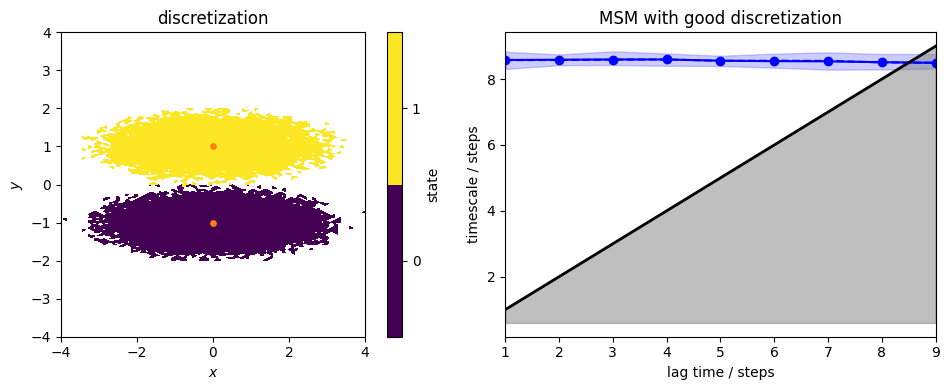

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_state_map(*data.T, good_dtraj, ax=axes[0])
axes[0].scatter(*np.asarray([[0, -1], [0, 1]]).T, s=15, c='C1')

axes[0].set_xlabel('$x$')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_aspect('equal')
axes[0].set_ylabel('$y$')
axes[0].set_title('discretization')

lags = [i for i in range(1, 10)]
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(good_dtraj, lags=lags, errors='bayes'), ylog=False, ax=axes[1])
axes[1].set_title('MSM with good discretization')
fig.tight_layout()

We note that for this very good discretization, the implied timescales are converged  from lagtime $1$ step.
We continue to build an MSM object and perform the Chapman-Kolmogorov test:

estimating MaximumLikelihoodMSM:   0%|                                     | 0/9 [00:00<?, ?it/s]

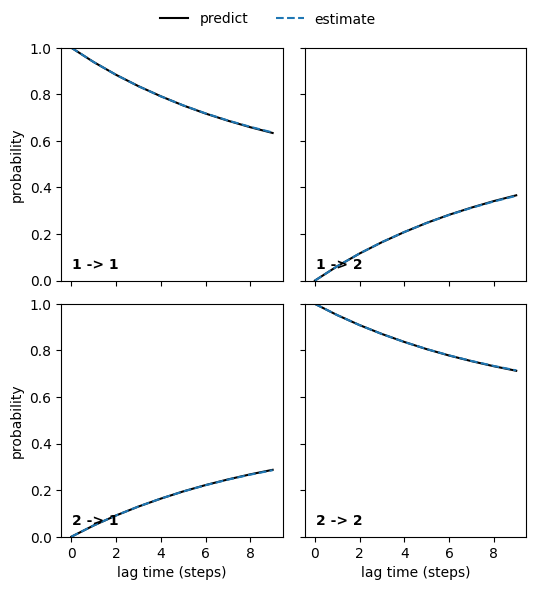

In [4]:
reference_msm = pyemma.msm.estimate_markov_model(good_dtraj, lag=1)
pyemma.plots.plot_cktest(reference_msm.cktest(2));

The Chapman-Kolmogorov test shows excellent agreement between higher lagtime estimation and model prediction.
We thus take this model as a reference.

Let's now deliberately choose a very bad discretization...

In [5]:
poor_clustercenters = np.asarray([[-2.5, -1.4], 
                                  [0.3, 1.2], 
                                  [2.7, -0.6]])
poor_dtraj = pyemma.coordinates.assign_to_centers(data, centers=poor_clustercenters)[0]

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "assign_to_centers". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.ClusterModel instead.
  return caller(func, *(extras + args), **kw)
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


... and repeat the ITS estimation:

estimating BayesianMSM:   0%|                                              | 0/9 [00:00<?, ?it/s]

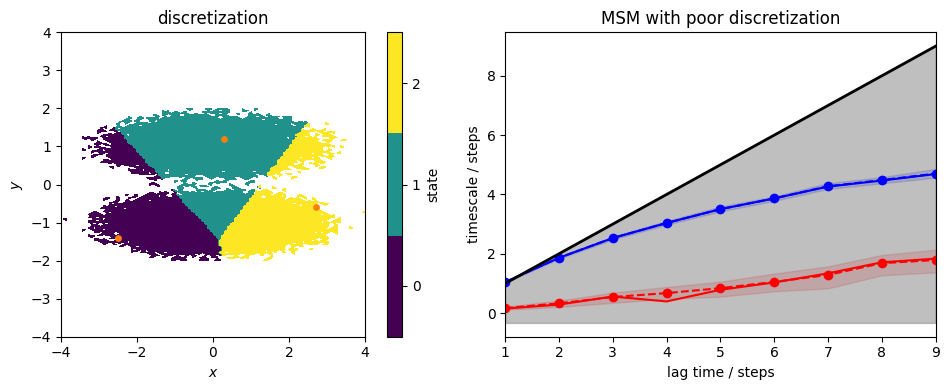

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_state_map(*data.T, poor_dtraj, ax=axes[0])
axes[0].scatter(*poor_clustercenters.T, s=15, c='C1')

axes[0].set_xlabel('$x$')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_aspect('equal')
axes[0].set_ylabel('$y$')
axes[0].set_title('discretization')

pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(poor_dtraj, lags=lags, errors='bayes'), ylog=False, ax=axes[1])
axes[1].set_title('MSM with poor discretization')
fig.tight_layout()

Obviously, the discretization is very poor and does not mirror the basins of the double-well potential anymore.
All three discrete states include data points from the two metastable regions (left panel) and,
as the right panel shows, this discretization error cannot be fixed by using a large lagtime for a regular MSM estimation.
Thus, the MSM clearly is not able to resolve the slow process connecting the two basins.

⚠️ We do not see any ITS above the lag time horizon and, hence, cannot estimate any MSM with this discretization.

Let us now repeat both estimations, using well and poorly discretized data, with hidden Markov models instead of regular MSMs.
We begin with the implied timescale convergence using the `pyemma.msm.timescales_hmsm()` function and two hidden states:

In [7]:
its_hmm_poor = pyemma.msm.timescales_hmsm(poor_dtraj, 2, lags=lags, errors='bayes')
its_hmm_good = pyemma.msm.timescales_hmsm(good_dtraj, 2, lags=lags, errors='bayes')

estimating BayesianHMSM:   0%|                                             | 0/9 [00:00<?, ?it/s]

estimating BayesianHMSM:   0%|                                             | 0/9 [00:00<?, ?it/s]

We go on visualizing the results as with regular MSM implied timescales and include, as a dotted line,
the result from our previously estimated reference MSM. 

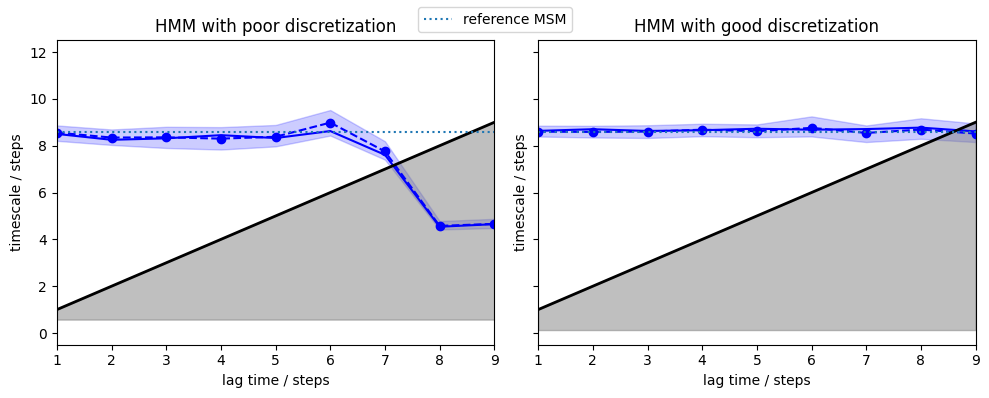

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
pyemma.plots.plot_implied_timescales(
    its_hmm_poor,
    ylog=False, ax=axes[0])
pyemma.plots.plot_implied_timescales(
    its_hmm_good,
    ylog=False, ax=axes[1])
axes[0].set_title('HMM with poor discretization')
axes[1].set_title('HMM with good discretization')

for n, ax in enumerate(axes.flat):
    ax.set_ylim(-0.5, 12.5)
    ax.hlines(reference_msm.timescales()[0], *ax.get_xlim(), linestyle=':', label='reference MSM' if n == 0 else None)
fig.legend(loc=9)
fig.tight_layout()

In contrast to a regular MSM, both discretizations give us converged implied timescales from the very start (lagtime $1$ step).
The only difference is that the poor discretization yields a larger error and we loose the process faster.
As the HMM computes the implied timescales of a process between two hidden states,
we do not assume Markovianity in the original state space.
Thus, the deliberate discretization error we made is compensated by the algorithm,
making it robust against poor clustering.

In order to validate this claim, we estimate HMMs using both discretizations at lagtime $1$ step and two hidden states...

In [9]:
poor_hmm = pyemma.msm.estimate_hidden_markov_model(poor_dtraj, 2, lag=1)
good_hmm = pyemma.msm.estimate_hidden_markov_model(good_dtraj, 2, lag=1)

print('MSM (ref):  1. implied timescale = {:.2f} steps'.format(reference_msm.timescales()[0]))
print('HMM (poor): 1. implied timescale = {:.2f} steps'.format(poor_hmm.timescales()[0]))
print('HMM (good): 1. implied timescale = {:.2f} steps'.format(good_hmm.timescales()[0]))

MSM (ref):  1. implied timescale = 8.58 steps
HMM (poor): 1. implied timescale = 8.51 steps
HMM (good): 1. implied timescale = 8.62 steps


... and obtain nearly identical estimates for the first implied timescale that agree with the reference MSM.

We observe that HMMs, unlike MSMs, seem to be somewhat resistant to discretization errors.

Regarding the CK test, we again see that the `poor_hmm`...

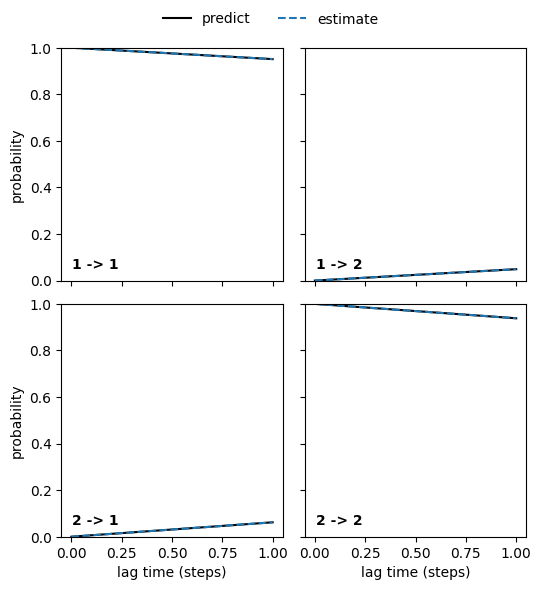

In [10]:
pyemma.plots.plot_cktest(poor_hmm.cktest(2));

... and the `good_hmm`...

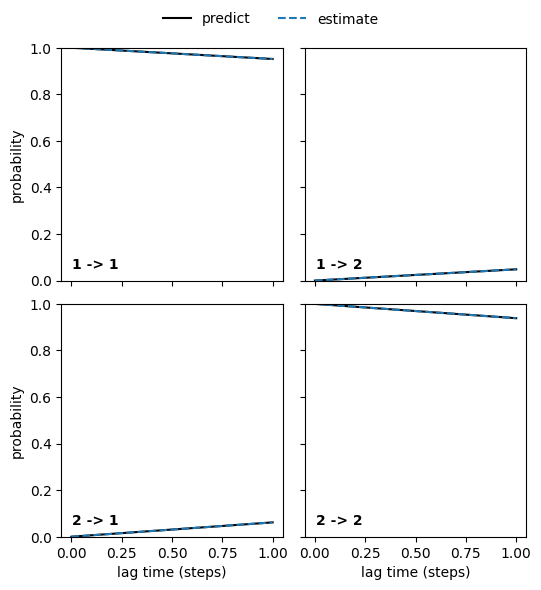

In [11]:
pyemma.plots.plot_cktest(good_hmm.cktest(2));

... are in perfect agreement and the Chapman-Kolmogorov test has passed.

The HMM, even for the poor discretization, has learned an assignment between the microstates to the hidden states that reflects the true dynamics.
We can extract this information from the HMM object using its `hmm.hidden_state_probabilities` property.
It contains the probabilities for each microstate to be in a given hidden state over time,
for each trajectory (which is why we have to take the $0$-th element from this list). 

Please note that there is also a time-independent property that contains the observation probabilities of a hidden state as a function of the microstates.
It is stored in `hmm.observation_probabilities` but not demonstrated here.

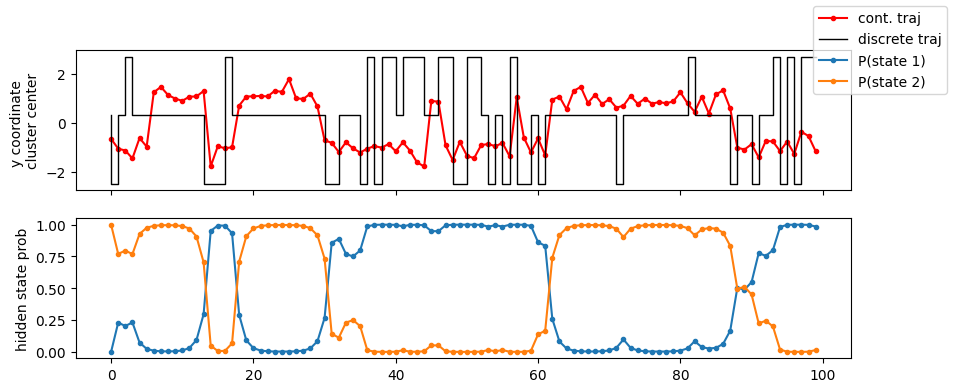

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
axes[0].plot(data[:100, 1], 'r.-', label='cont. traj')
axes[0].step(np.arange(100), poor_clustercenters[poor_dtraj[:100], 0], label='discrete traj', linewidth=1, c='k')
axes[0].set_ylabel('y coordinate \ncluster center')

for n, hidden_state_probability_traj in enumerate(poor_hmm.hidden_state_probabilities[0].T):
    axes[1].plot(hidden_state_probability_traj[:100], '.-', label='P(state {})'.format(n + 1))
    
axes[1].set_ylabel('hidden state prob')
fig.legend();

As we see in the trajectory excerpt of the first $100$ steps,
the microstate assignment probabilities to hidden states over time reflect the actual dynamics very well,
even though the discrete trajectory has basically lost notion of the original double-well basins.

Let's now plot the hidden state probabilities in the original space:

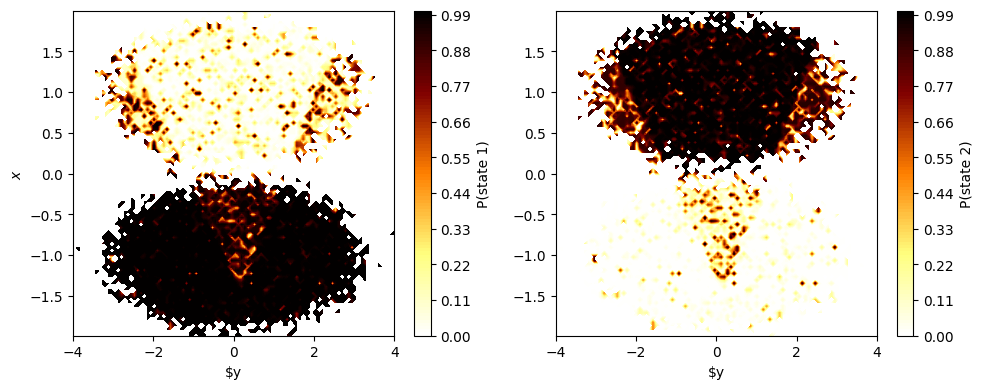

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *data.T,
        poor_hmm.hidden_state_probabilities[0][:, i], # index 0: only 1 trajectory
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='P(state {})'.format(i+1))
    ax.set_xlabel('$y')
axes[0].set_ylabel('$x$')
fig.tight_layout()

Even though we find some artifacts of the initial clustering,
the HMM has basically overcome the poor discretization and found hidden states that,
with high certainty, mirror the original double-well basins.

Let's finish this example by comparing the hidden state trajectories with the discrete trajectories that were used for estimating the reference MSM (the "true" discrete trajectories)...

In [14]:
print('HMM (good): Hidden state trajectory consistency: '
      '{:.3f}'.format(sum(good_hmm.hidden_state_trajectories[0] == good_dtraj)/good_dtraj.shape[0]))
print('HMM (poor): Hidden state trajectory consistency: '
      '{:.3f}'.format(sum(poor_hmm.hidden_state_trajectories[0] == good_dtraj)/good_dtraj.shape[0]))

HMM (good): Hidden state trajectory consistency: 1.000
HMM (poor): Hidden state trajectory consistency: 0.946


... and the stationary distributions of both HMMs to the reference MSM:

In [15]:
print('MSM (ref):  stationary distribution = {}'.format(np.round(reference_msm.pi, 4)))
print('HMM (poor): stationary distribution = {}'.format(np.round(poor_hmm.pi, 4)))
print('HMM (good): stationary distribution = {}'.format(np.round(good_hmm.pi, 4)))

MSM (ref):  stationary distribution = [0.5603 0.4397]
HMM (poor): stationary distribution = [0.5583 0.4417]
HMM (good): stationary distribution = [0.5604 0.4396]


We find that even with a very poor discretization,
HMMs are capable of recovering the kinetics of the underlying process with very little error. 

## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)

We are now illustrating a typical use case of hidden markov state models:
estimating an MSM that is used as a heuristics for the number of slow processes or hidden states,
and estimating an HMM (to overcome potential discretization issues and to resolve faster processes than an MSM).

We fetch the alanine dipeptide data set, load the backbone torsions into memory...

In [16]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
data_concatenated = np.concatenate(data)

cluster = pyemma.coordinates.cluster_kmeans(data, k=75, max_iter=50, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

Obtaining file info:   0%|                                                 | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                                     | 0/3 [00:00<?, ?it/s]

/home/cadeniran/.local/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/cadeniran/.local/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                                        | 0/75 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                  | 0/50 [00:00<?, ?it/s]

07-03-25 10:10:56 pyemma.coordinates.clustering.kmeans.KmeansClustering[18] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/cadeniran/.local/lib/python3.11/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


getting output of KmeansClustering:   0%|                                  | 0/3 [00:00<?, ?it/s]

... discretize the full space using $k$-means clustering,
visualize the marginal and joint distributions of both components as well as the cluster centers,
and show the ITS convergence to help selecting a suitable lag time:

estimating BayesianMSM:   0%|                                              | 0/6 [00:00<?, ?it/s]

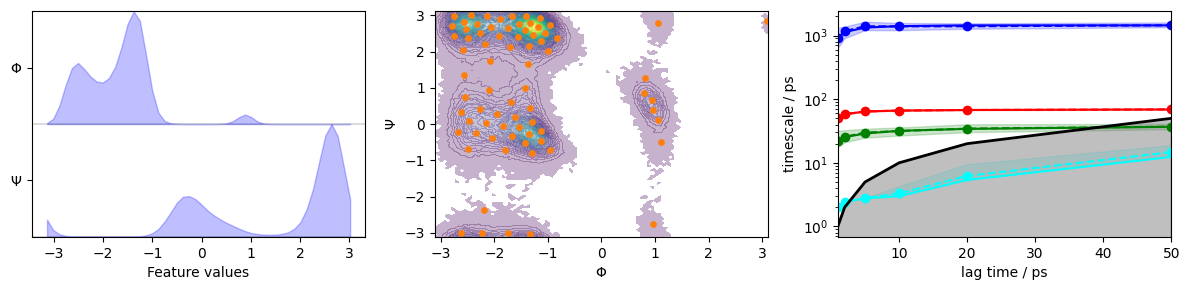

In [17]:
its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*data_concatenated.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.clustercenters.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

Based on the implied timescale convergence plot, we choose a lagtime of $10$ ps.
We further find $3$ slow processes in the implied timescales plot,
meaning that we can expect $4$ metastable sets or hidden states.

First, we estimate a Bayesian MSM, and show the results of a CK test:

pyemma.msm.estimators.bayesian_msm.BayesianMSM[22]: Sampling MSMs:   0%| | 0/100 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                                              | 0/9 [00:00<?, ?it/s]

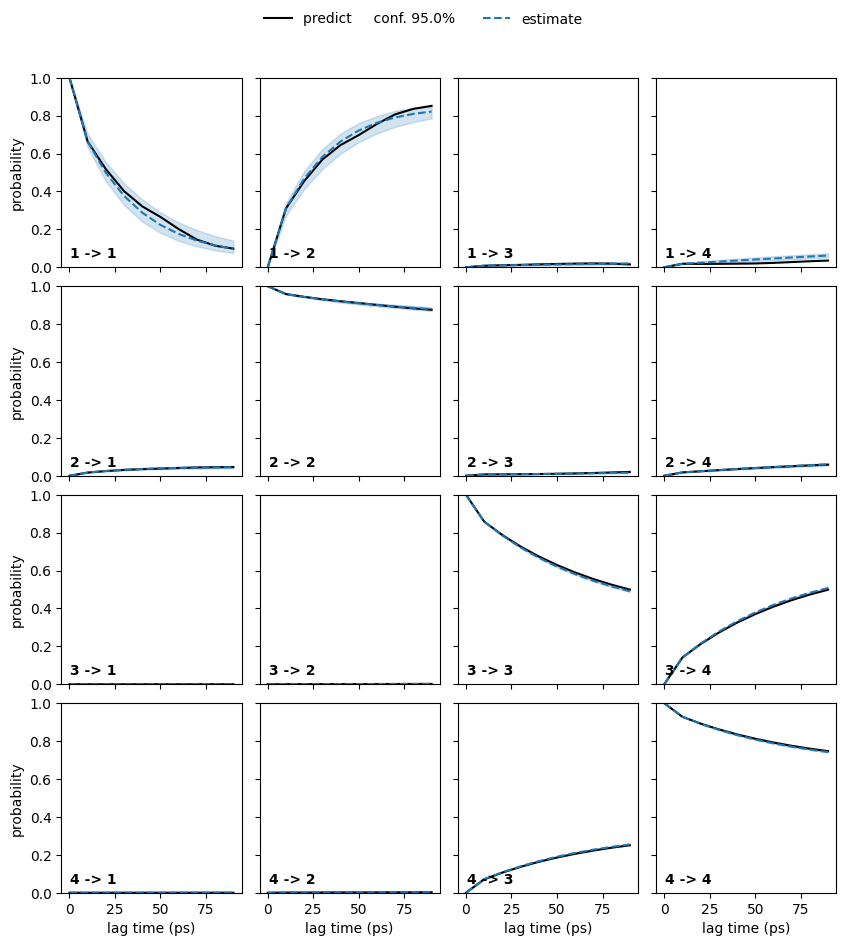

In [18]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=10, dt_traj='1 ps')

nstates = 4
pyemma.plots.plot_cktest(bayesian_msm.cktest(nstates), units='ps');

At this point, we have a (bayesian) MSM with $75$ discrete states and basic validation.
To obtain an HMM with only four states (the number for which we have validated our MSM),
we compute the implied timescales for HMMs with this number of hidden states. 

We repeat the ITS convergence analysis using (bayesian) HMMs and small lagtimes for a $4$-state HMM.
For demonstration purposes, we add the same analysis with a $6$-state HMM to visualize what happens if the number of states is not as clear as in this example: 

⚠️ Executing the following cell might take a few minutes.

estimating BayesianHMSM:   0%|                                             | 0/4 [00:00<?, ?it/s]

/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warn

estimating BayesianHMSM:   0%|                                             | 0/4 [00:00<?, ?it/s]

/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warn

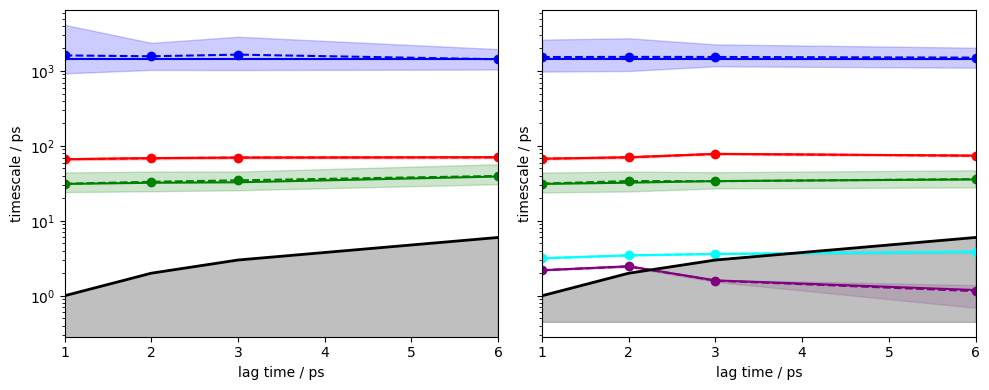

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
pyemma.plots.plot_implied_timescales(
    pyemma.msm.timescales_hmsm(
        cluster.dtrajs, 4, lags=[1, 2, 3, 6], errors='bayes', nsamples=50),
    ax=axes[0], units='ps')
pyemma.plots.plot_implied_timescales(
    pyemma.msm.timescales_hmsm(
        cluster.dtrajs, 6, lags=[1, 2, 3, 6], errors='bayes', nsamples=50),
    ax=axes[1], units='ps')
fig.tight_layout()

The left panel shows that an HMM with four hidden states yields converged implied timescales from lagtime $1$.

The right panel, however, shows that an HMM with six hidden states and lagtime $1$ can resolve two additional processes.

Let us follow up on this and perform a CK test for a four state HMM at lagtime $1$...

In [20]:
hmm_4 = pyemma.msm.bayesian_hidden_markov_model(cluster.dtrajs, 4, lag=1, dt_traj='1 ps', nsamples=50)
pyemma.plots.plot_cktest(hmm_4.cktest(mlags=6), units='ps');

/opt/Python-3.11.10/lib/python3.11/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


Sampling HMSMs:   0%|                                                     | 0/50 [00:00<?, ?it/s]

TypeError: ProgressCallback.__init__() got an unexpected keyword argument 'desc'

... and than the six state HMM at laggtime $1$ (we use `mlags=2` because we would loose the two fast processes at lagtimes $\geq3$):

⚠️ Executing the following cell might take a few minutes.

In [ ]:
hmm_6 = pyemma.msm.bayesian_hidden_markov_model(cluster.dtrajs, 6, lag=1, dt_traj='1 ps', nsamples=50)
pyemma.plots.plot_cktest(hmm_6.cktest(mlags=2), units='ps');

In both cases, the CK test is passed.

If we now compare both metastable membership plots...

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for hmm, ax in zip([hmm_4, hmm_6], axes.flat):
    _, _, misc = pyemma.plots.plot_state_map(
        *data_concatenated.T,
        hmm.metastable_assignments[dtrajs_concatenated], 
        ax=ax)
    ax.set_title('HMM with {} hidden states'.format(hmm.nstates))
    ax.set_xlabel('$\Phi$')
    misc['cbar'].set_ticklabels(range(1, hmm.nstates + 1))
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()

... we see that the six state HMM is able to subdivide the two largest metastable states of the four state HMM and,
thus, gives us a more detailed view on the underlying system.
As one would have expected from the implied timescale plot,
the metastable dynamics is already well-described with $4$ hidden states.

⚠️ Due to the low sensibility to discretization errors,
we can additionally afford to estimate HMMs at smaller lagtimes than MSMs and,
thus, resolve more processes.

Like with classical MSMs, we can further analyze properties of the HMM.
As an example, have a look at the transition paths and committor probabilities below. 

In [ ]:
A = [0]
B = [3]
flux = pyemma.msm.tpt(hmm_4, A, B)

highest_membership = hmm_4.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[hmm_4.observable_set[highest_membership]]

Please note one important difference to MSMs:
since HMMs operate directly on the hidden states,
we must not compute the flux between the `msm.metastable_sets` but between the lists of macrostate numbers,
e.g., instead of `A = msm.metastable_sets[0]` we set `A = [0]`. 

Let's now visualize the committor as before.
Does it look familiar?

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

pyemma.plots.plot_contour(
    *data_concatenated.T,
    flux.committor[hmm_4.metastable_assignments[dtrajs_concatenated]],
    cmap='brg',
    ax=ax,
    mask=True,
    cbar_label=r'committor 0 $\to$ 3',
    alpha=0.8,
    zorder=-1)

pyemma.plots.plot_flux(
    flux,
    coarse_state_centers,
    flux.stationary_distribution,
    ax=ax,
    show_committor=False,
    figpadding=0,
    show_frame=True,
    state_labels=['A','' ,'', 'B'], 
    arrow_label_format='%2.e / ps');

ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
ax.set_xlim(data_concatenated[:, 0].min(), data_concatenated[:, 0].max())
ax.set_ylim(data_concatenated[:, 1].min(), data_concatenated[:, 1].max())
fig.tight_layout()

As we see, in addition to the properties described above, HMMs provide the same analysis tools as MSMs.
For example, eigenvectors and mean first passage times can be extracted as described in [Notebook 04 ➜ 📓](04-msm-analysis.ipynb) and [Notebook 05 ➜ 📓](05-pcca-tpt.ipynb). 

Let us now repeat this approach again for another featurization:
we already know that it is possible to resolve six metastable states (five slow processes) using an HMM estimated on a discretization of the backbone torsions.
Can you achieve the same level of resolution using heavy atom distances and a suitable TICA projection?

#### Exercise 1

Obtain the heavy atom distances, use TICA for dimension reduction, and discretize using a method of your choice.

In [ ]:
feat = #FIXME
feat. #FIXME
data = #FIXME

tica = #FIXME
tica_concatenated = np.concatenate(tica.get_output())

cluster = #FIXME
dtrajs_concatenated = #FIXME

its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters[:, :2].T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

###### Solution

In [ ]:
feat = pyemma.coordinates.featurizer(pdb)
pairs = feat.pairs(feat.select_Heavy())
feat.add_distances(pairs, periodic=False)
data = pyemma.coordinates.load(files, features=feat)

tica = pyemma.coordinates.tica(data, lag=3)
tica_concatenated = np.concatenate(tica.get_output())

cluster = pyemma.coordinates.cluster_kmeans(tica, k=75, max_iter=50, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 5, 10, 20, 50], nits=4, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(tica_concatenated, ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(*cluster.clustercenters[:, :2].T, s=15, c='C1')
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
pyemma.plots.plot_implied_timescales(its, ax=axes[2], units='ps')
fig.tight_layout()

#### Exercise 2
Let's see if your discretized data is suitable to converge five slow implied timescales using a bayesian HMM.

In [ ]:
pyemma.plots.plot_implied_timescales #FIXME

###### Solution

In [ ]:
pyemma.plots.plot_implied_timescales(
    pyemma.msm.timescales_hmsm(
        cluster.dtrajs, 6, lags=[1, 2, 3, 4], errors='bayes'), units='ps');

#### Exercise 3
Estimate a bayesian HMM and perform a CK test.

In [ ]:
hmm = #FIXME
pyemma.plots. #FIXME

###### Solution

In [ ]:
hmm = pyemma.msm.bayesian_hidden_markov_model(cluster.dtrajs, 6, lag=1, dt_traj='1 ps')
pyemma.plots.plot_cktest(hmm.cktest(mlags=2), units='ps');

#### Exercise 4
Now that you have a model, be creative and visualize the metastable regions in your projected space.

In [ ]:
#FIXME

###### Solution

In [ ]:
def draw_panel(ax, i, j):
    _, _, misc = pyemma.plots.plot_state_map(
        *tica_concatenated[:, [i, j]].T,
        hmm.metastable_assignments[dtrajs_concatenated],
        ax=ax)
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
    misc['cbar'].set_ticklabels(range(1, hmm.nstates + 1))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
draw_panel(axes[0, 0], 0, 2)
draw_panel(axes[0, 1], 1, 2)
draw_panel(axes[1, 0], 0, 1)
axes[1, 1].set_axis_off()
fig.tight_layout()

## Case 3: another molecular dynamics data set (pentapeptide)

Let us now repeat the analysis of our pentapeptide using an HMM.

We fetch the pentapeptide data set and prepare the discrete trajectories as explained in [Notebook 00 ➜ 📓](00-pentapeptide-showcase.ipynb).
There, we already learned that $5$ metastable states are a good choice for our model.
According to our implied timescales plot, we can resolve four processes for up to $2.5$ ns in our data. 

In [ ]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)

tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=75, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

#### Exercise 5

Please go ahead and estimate an HMM with $5$ hidden states by probing for timescales convergence for up to $2.5$ ns with Bayesian error estimation:

In [ ]:
nstates = #FIXME
its_hmm = #FIXME
pyemma.plots.plot_implied_timescales(its_hmm, units='ns', dt=0.1);

###### Solution

In [ ]:
nstates = 5
its_hmm = pyemma.msm.timescales_hmsm(cluster.dtrajs, nstates, lags=25, errors='bayes')
pyemma.plots.plot_implied_timescales(its_hmm, units='ns', dt=0.1);

We note that the ITS are converged within the error from $0.1$ ns, earlier than regular MSMs due to the mentioned compensation of discretization error. 


#### Exercise 6

Estimate a Bayesian HMM at this lag time and conduct the CK-validation.

In [ ]:
hmm = #FIXME

cktest = hmm.cktest(mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

###### Solution

In [ ]:
hmm = pyemma.msm.bayesian_hidden_markov_model(cluster.dtrajs, nstates, lag=1, dt_traj='0.1 ns')

cktest = hmm.cktest(mlags=6)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');

#### Exercise 7

Plot the state map of the hidden states:

In [ ]:
metastable_traj = #FIXME

fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, [0, 1]].T, metastable_traj, ax=ax)

misc['cbar'].set_ticklabels(range(1, hmm.nstates + 1))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

fig.tight_layout()

###### Solution

In [ ]:
metastable_traj = hmm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, [0, 1]].T, metastable_traj, ax=ax)

misc['cbar'].set_ticklabels(range(1, hmm.nstates + 1))
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')

fig.tight_layout()

We find state definitions that are similar than the PCCA++ ones but not the same.
Especially, the largest basin in the 2D TICA projection has become separated into different hidden states.
The reason might be that several metastable states are projected onto the same region by TICA and,
after clustering, could not be resolved by a regular MSM anymore.

Another benefit of HMMs is that transition matrices between the hidden states are computed as part of the algorithm.
Any property derived from it, e.g. the stationary distribution, can directly be computed.

#### Exercise 8:

Visualize the transition probabilities and stationary probabilities.
It might be useful to check out `pyemma.plots.plot_markov_model()`.

In [ ]:
#FIXME

###### Solution

In [ ]:
pyemma.plots.plot_markov_model(hmm);

#### Exercise 9:

In the last step, save some (e.g. $50$) representative structures of the pentapeptide to disk.
You might want to use your favorite molecular dynamics viewer and have a look at the structures
(it might be necessary to align them, though).

In [ ]:
hmm_samples = #FIXME

data_source = pyemma.coordinates.source(files, features=torsions_feat)

pyemma.coordinates.save_trajs(
    data_source,
    hmm_samples,
    outfiles=['./data/hmm_{}.pdb'.format(n + 1)
              for n in range(hmm.nstates)])

###### Solution

In [ ]:
hmm_samples = hmm.sample_by_observation_probabilities(50)

data_source = pyemma.coordinates.source(files, features=torsions_feat)

pyemma.coordinates.save_trajs(
    data_source,
    hmm_samples,
    outfiles=['./data/hmm_{}.pdb'.format(n + 1)
              for n in range(hmm.nstates)])

## Wrapping up

In this notebook, we have learned how to use a hidden Markov state model (HMM) and how they differ from an MSM.
In detail, we have used
- `pyemma.msm.timescales_hmsm()` function to obtain an implied timescale object for HMMs,
- `pyemma.msm.estimate_hidden_markov_model()` to estimate a regular HMM,
- `pyemma.msm.bayesian_hidden_markov_model()` to estimate a Bayesian HMM, 
- the `metastable_assignments` attribute of an HMM object to access the metastable membership of discrete states, 
- the `hidden_state_probabilities` attribute to assess probabilities of hidden states over time, and
- the `hidden_state_trajectories` attribute that extracts the most likely trajectory in hidden state space.

## References

<a id="cite-hmm-baum-welch-alg"/><sup><a href=#ref-1>[^]</a></sup>Leonard E. Baum and Ted Petrie and George Soules and Norman Weiss. 1970. _A Maximization Technique Occurring in the Statistical Analysis of Probabilistic Functions of Markov Chains_. [URL](http://www.jstor.org/stable/2239727)

<a id="cite-noe-proj-hid-msm"/><sup><a href=#ref-2>[^]</a></sup>Frank Noé and Hao Wu and Jan-Hendrik Prinz and Nuria Plattner. 2013. _Projected and hidden Markov models for calculating kinetics and metastable states of complex molecules_. [URL](https://doi.org/10.1063/1.4828816)

<a id="cite-hmm-tutorial"/><sup><a href=#ref-3>[^]</a></sup>L.R. Rabiner. 1989. _A tutorial on hidden Markov models and selected applications in speech recognition_. [URL](https://doi.org/10.1109/5.18626)

